# Introduction 

This project aims to explore the topic of Paleoclimatolgy and show the corralations between CO2 levels polar ice and rainfall as the key variables, This research also seeks to investigate climate change signals within the context of Ireland's meteorological observations and harnesses data fusion techniques to amalgamate multiple datasets into a structured pandas dataframe. 

# what is Paleoclimatology 

Paleoclimatology is the study of the climate history of earth. This science allows for a better understanding of the climate of Earth in the past and how it relates to present and future climates on the planet. Earths climate past cannot be found in modern records. Therefore, scientists must gather data preserved in nature over the millennia in paleological remains referred to as proxy records. An example of a type of proxy data is when scientists drill into ice sheets and extract ice cores to analyse deposits trapped within the ice, such as pollen and gas. This gives insights into the atmospheric and climatic conditions that existed when particular layers of the sheet formed. These studies have shown that the climate of Earth is always changing. Research revealed that there have been several ice ages as well as several periods of global warming. An ice age is a period of colder global temperatures and recurring glacial expansion capable of lasting hundreds of millions of years. Paleoclimatology has shown that other enviromental factors such as continental drift, greenhouses gases in the atmosphere, solar energy, and the variation in Earth’s orbit have all affected the climate of Earth over time. This type of science is vital to our understanding of climate on Earth. Models can be developed to help predict how increased carbon dioxide levels and other changes may impact the climate of Earth in years to come.

In [309]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import sys 
from sklearn.impute import SimpleImputer
import random
from plotly.offline import iplot
from plotnine import ggplot, aes, geom_line, geom_bar, geom_point, labs, coord_flip, theme_xkcd, geom_smooth
import json 
import warnings 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import scipy.fft
from scipy.fft import fft, fftfreq
from scipy.interpolate import interp1d


# Global warming 
The topic of global warming is more prevalant than ever. There are many factor that give rise to global warming, we will review some of these during these project along with their effects which can be seen world wide, the World is getting warmer. We are seen more storms and rising waters. All of which have been caused by human factors as we should discovery during this project. One of the biggest of these factors been fossil fuels which was one of the main focuses As the human population has increased, so has the volume of fossil fuels burned. Global warming has presented another issue called climate change. Sometimes these phrases are used interchangeably, however, they are different. Climate change refers to changes in weather patterns and growing seasons around the world. This led to the recent cop28 discussions held in Dubai. This is all part of the push to net zero. 

# what is net zero

Net zero means no longer adding to the total amount of greenhouse gases in the atmosphere. Greenhouse gases include carbon dioxide (CO2) and methane. CO2 is released when oil, gas and coal are burned in homes, factories and to power transport. Methane is produced through farming and landfill. Under the 2015 Paris climate agreement, 197 countries agreed to try to limit global temperature rises to 1.5C by 2100. To achieve this, CO2 emissions need to fall by nearly half by 2030 and reach net zero by 2050, according to the UN's climate body, the IPCC. But these emissions remain at record highs. In Ireland this forms part of the  Climate Action and Low Carbon Development Bill. Currently fossil fuels makes up 85% of Ireland's energy needs.

# CO2 

The average temperature at the Earth's surface has risen about 1.1C since 1850. Carbon dioxide is Earth’s most important greenhouse gas: a gas that absorbs and radiates heat. Unlike oxygen or nitrogen (which make up most of our atmosphere), greenhouse gases absorb heat radiating from the Earth’s surface and re-release it in all directions—including back toward Earth’s surface. Without carbon dioxide, Earth’s natural greenhouse effect would be too weak to keep the average global surface temperature above freezing. Carbon dioxide concentrations are rising mostly because of the fossil fuels that people are burning for energy as stated previously.  





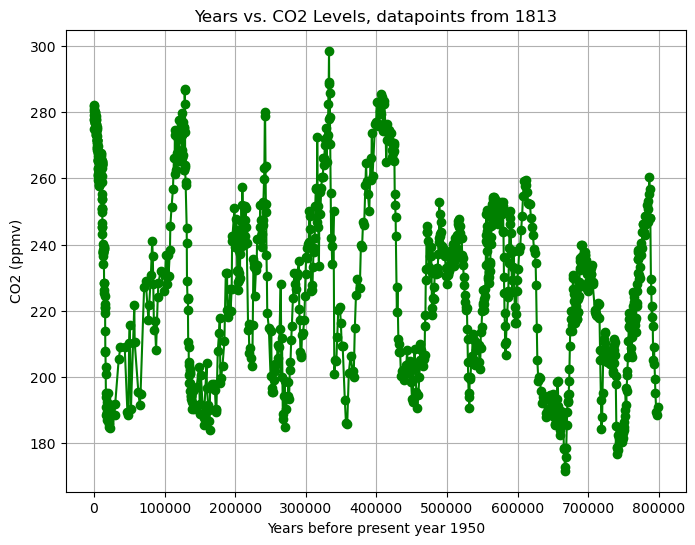

In [310]:

nature = pd.read_excel('data/C02 Nature Paper.xlsx', skiprows=6, sheet_name='3.  Composite CO2')

# Handling NaN values (if any)
nature.dropna(subset=['EDC3_gas_a (yr)', 'CO2 (ppmv)'], inplace=True)

# Extract data from the first two columns
years = nature['EDC3_gas_a (yr)']
co2 = nature['CO2 (ppmv)']

# Plotting the extracted data with the same formatting
plt.figure(figsize=(8, 6))
plt.plot(years, co2, marker='o', linestyle='-', color='green')
plt.xlabel('Years before present year 1950')
plt.ylabel('CO2 (ppmv)')
plt.title('Years vs. CO2 Levels, datapoints from 1813')
plt.grid(True)
plt.show()

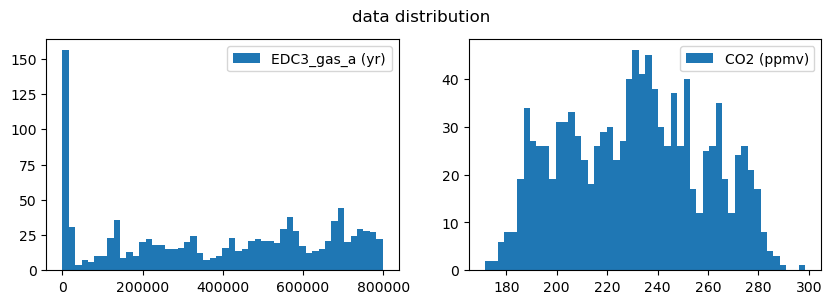

In [311]:
fig, axs = plt.subplots(1,2, figsize=(10,3)) # 1 row, 3 columns
# Age
axs[0].hist(nature['EDC3_gas_a (yr)'],label="EDC3_gas_a (yr)",bins=50)
axs[0].legend()
# Temperature
axs[1].hist(nature['CO2 (ppmv)'],label="CO2 (ppmv)", bins=50)
axs[1].legend()
plt.suptitle("data distribution")
plt.show()

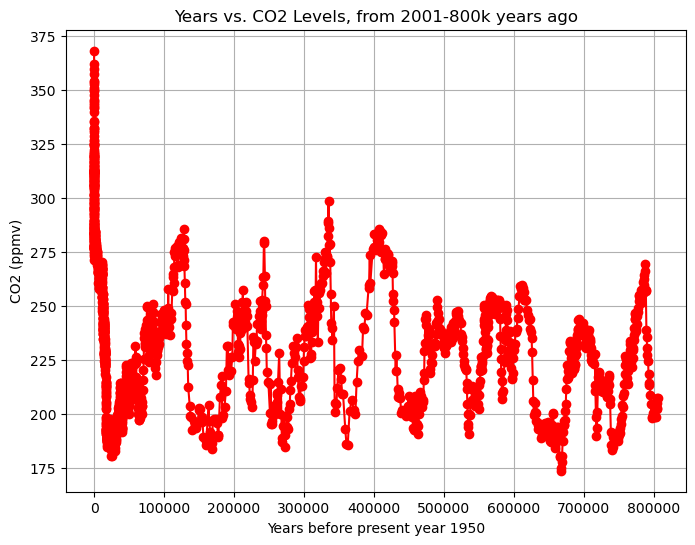

In [312]:

ipcc = pd.read_excel('data/C02 IPCC Report.xlsx',sheet_name= 'CO2 Composite',skiprows=range(14))

# Handling NaN values (if any)
ipcc.dropna(subset=['Gasage (yr BP) ', 'CO2 (ppmv)'], inplace=True)

# Extract data from the first two columns
Gasage = ipcc['Gasage (yr BP) ']
co22 = ipcc['CO2 (ppmv)']

# Plotting the extracted data with the same formatting
plt.figure(figsize=(8, 6))
plt.plot(Gasage, co22, marker='o', linestyle='-', color='red')
plt.xlabel('Years before present year 1950')
plt.ylabel('CO2 (ppmv)')
plt.title('Years vs. CO2 Levels, from 2001-800k years ago')
plt.grid(True)
plt.show()

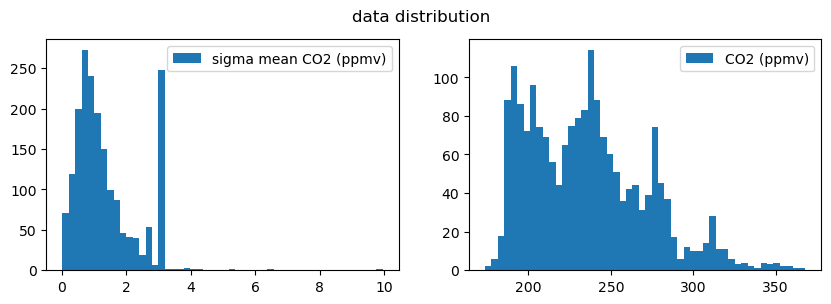

In [313]:
fig, axs = plt.subplots(1,2, figsize=(10,3)) # 1 row, 3 columns
axs[0].hist(ipcc['sigma mean CO2 (ppmv)'],label="sigma mean CO2 (ppmv)",bins=50)
axs[0].legend()
axs[1].hist(ipcc['CO2 (ppmv)'],label="CO2 (ppmv)", bins=50)
axs[1].legend()
plt.suptitle("data distribution")
plt.show()

In [314]:
mlo = pd.read_csv('data/loa.csv',skiprows=range(43))

In [315]:
mlo.columns = mlo.columns.str.lstrip()
mlo.columns = mlo.columns.str.rstrip()

In [316]:
base = 1950
mlo['year'] = base - mlo['year']

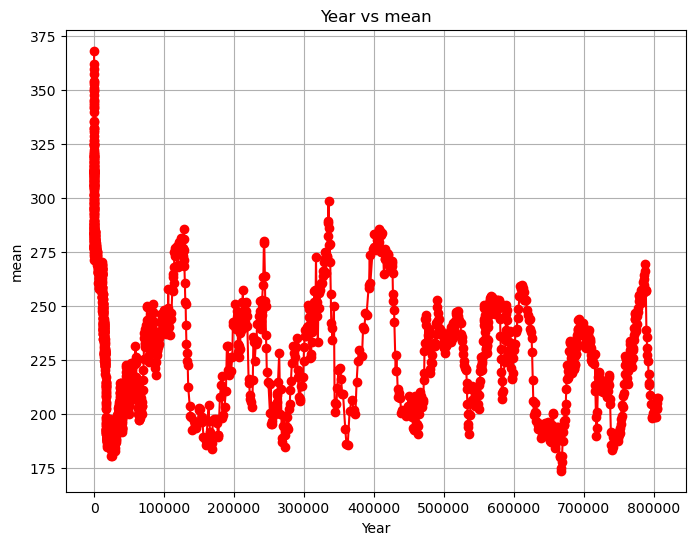

In [317]:

# Extract data from the first two columns
year = mlo['year']
mean = mlo['mean']

# Plotting the extracted data with the same formatting
plt.figure(figsize=(8, 6))
plt.plot(Gasage, co22, marker='o', linestyle='-', color='red')
plt.xlabel('Year')
plt.ylabel('mean')
plt.title('Year vs mean')
plt.grid(True)
plt.show()

In [318]:
mlo = mlo.rename(columns=(({'year':'EDC3_gas_a (yr)'})))
mlo = mlo.rename(columns=(({'mean':'CO2 (ppmv)'})))

In [319]:
mlo.columns = mlo.columns.str.lstrip()
mlo.columns = mlo.columns.str.rstrip()

In [320]:
mergeddf = pd.concat([mlo, nature])
mergeddf = mergeddf.drop(['unc'],axis =1)

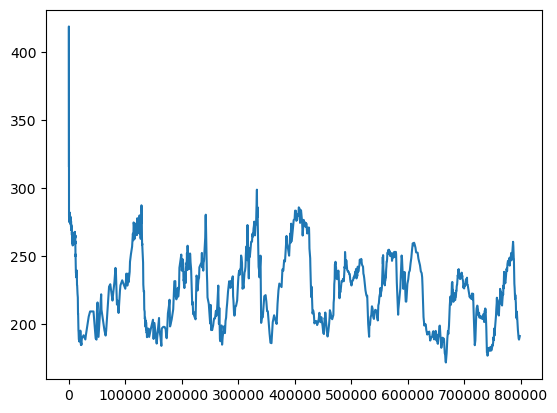

In [321]:
plt.plot(mergeddf['EDC3_gas_a (yr)'],mergeddf['CO2 (ppmv)'])
plt.show()

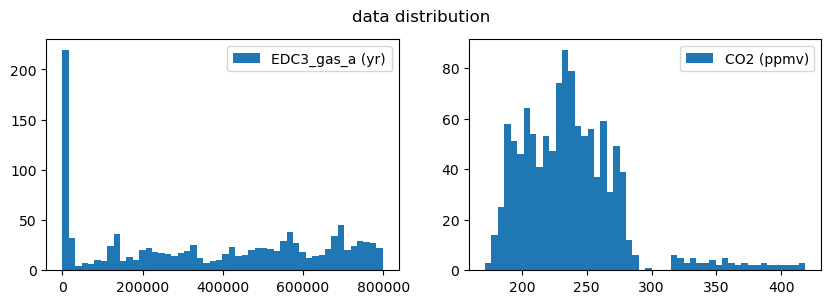

In [322]:
fig, axs = plt.subplots(1,2, figsize=(10,3)) # 1 row, 3 columns
axs[0].hist(mergeddf['EDC3_gas_a (yr)'],label="EDC3_gas_a (yr)",bins=50)
axs[0].legend()
axs[1].hist(mergeddf['CO2 (ppmv)'],label="CO2 (ppmv)", bins=50)
axs[1].legend()
plt.suptitle("data distribution")
plt.show()

# Temperature
according to wikipedia, Temperature is a physical quantity that quantitatively expresses the attribute of heat or cold. Temperature is measured with a thermometer. It reflects the kinetic energy of the vibrating and colliding atoms making up a substance. There are several scales used to measure temperature, these include Kelvin, Celsius, Fahrenheit, Absolute zero is 0 K on the Kelvin scale, −273.15 C on the Celsius scale, and −459.67 F on the Fahrenheit scale. The average temperature of the earths surface has had a gradual increase of 1.1c since the year 1850. To add to this the last four decades have been warmer than previous decades. And as a further side note to this it was stated that 2023 was the warmest year recorded on earth. Much research has been done into why temperature is rising there have been some generel conclolusion is that the industral age has caused this spike. The EL NINO affect has also aided this. 

The EL NINO effect is a climate pattern that describes the unusual warming of surface waters in the eastern tropical Pacific Ocean. El Niño has an impact on ocean temperatures, the speed and strength of ocean currents, the health of coastal fisheries, and local weather from Australia to South America and beyond. recent studies suggest that global heating may be leading to stronger El Niño events.

One recent study found that current sea surface temperature extremes driven by El Niño have intensified by around 10% compared to pre-1960 levels. This builds on previous studies which predicted that the frequency of extreme El Niño events could double over the next century due to faster surface warming of the eastern Pacific Ocean brought on by global temperature rises.

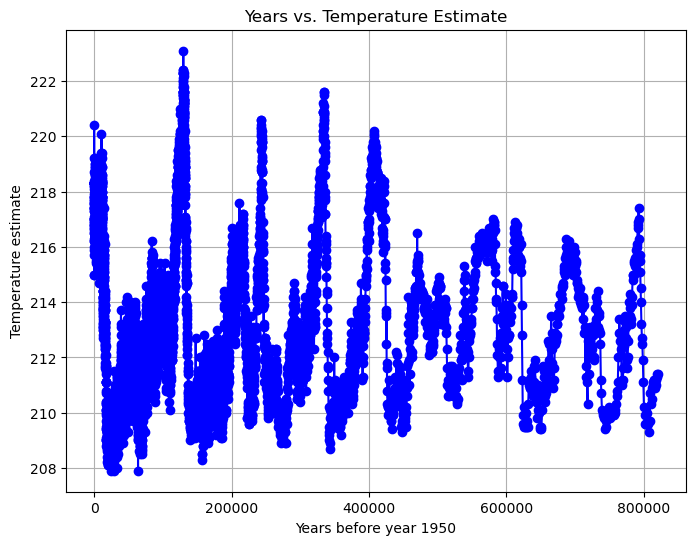

In [323]:
jouzel = pd.read_csv('data/jouzel.csv',encoding='Latin')

# Extracting columns 3 (EDC3 age scale) and 5 (Temperature estimate)
edc3_age = jouzel['EDC3béta']
temperature_estimate = jouzel['temp']

# Plotting the data
plt.figure(figsize=(8, 6))
plt.plot(edc3_age, temperature_estimate, marker='o', linestyle='-', color='blue')
plt.xlabel('Years before year 1950')
plt.ylabel('Temperature estimate')
plt.title('Years vs. Temperature Estimate')
plt.grid(True)
plt.show()

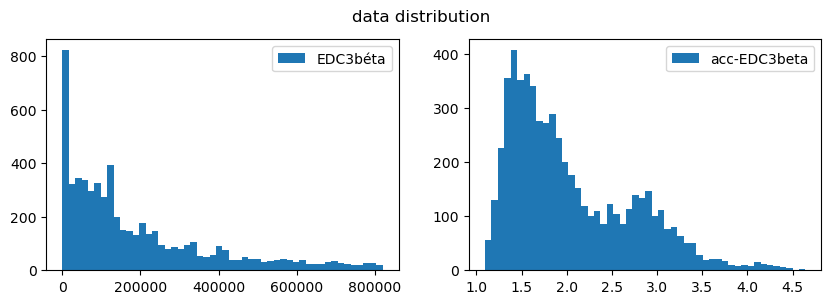

In [324]:
fig, axs = plt.subplots(1,2, figsize=(10,3)) # 1 row, 3 columns
axs[0].hist(jouzel['EDC3béta'],label="EDC3béta",bins=50)
axs[0].legend()

axs[1].hist(jouzel['acc-EDC3beta'],label="acc-EDC3beta", bins=50)
axs[1].legend()
plt.suptitle("data distribution")
plt.show()

In [325]:
jouzel =pd.read_csv('data/jouzel.csv',encoding='Latin')

jouzel['difference'] = jouzel['temp'] - 218.32
jouzel

,bag,ztop,EDC3béta,AICC2012,deutfinal,temp,acc-EDC3beta,difference
0,1,0.00,-50.00000,-55.000000,NaN,218.3,3.105321,-0.02
1,2,0.55,-43.55977,-50.513333,NaN,218.3,3.104805,-0.02
2,3,1.10,-37.44019,-46.026667,NaN,218.3,3.104404,-0.02
3,4,1.65,-31.64156,-41.540000,NaN,218.3,3.104025,-0.02
4,5,2.20,-24.55278,-34.516667,NaN,218.3,3.103453,-0.02
...,...,...,...,...,...,...,...,...
5814,5815,3197.70,816871.60000,817562.000000,-432.2,211.0,1.529000,-7.32
5815,5816,3198.25,817693.60000,818631.000000,-431.4,211.2,1.548000,-7.12
5816,5817,3198.80,818505.50000,819700.000000,-430.3,211.3,1.576000,-7.02
5817,5818,3199.35,819303.10000,820769.000000,-429.8,211.4,1.589000,-6.92


In [326]:
jouzel['celsius'] = jouzel['temp'] - 273.15

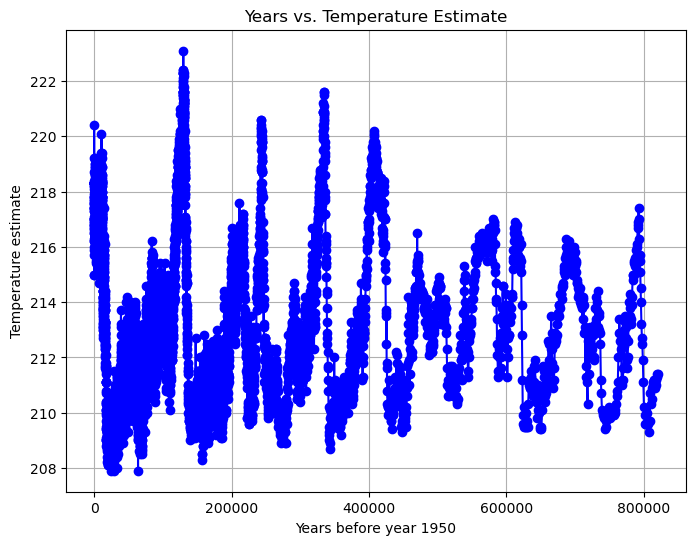

In [327]:
edc3_age = jouzel['EDC3béta']
temperature_estimate = jouzel['temp']

# Plotting the data
plt.figure(figsize=(8, 6))
plt.plot(edc3_age, temperature_estimate, marker='o', linestyle='-', color='blue')
plt.xlabel('Years before year 1950')
plt.ylabel('Temperature estimate')
plt.title('Years vs. Temperature Estimate')
plt.grid(True)
plt.show()

In [328]:
noaa =pd.read_csv('data/Temp data NOAA.csv',skiprows=range(91),delimiter=r"\s+")
noaa2 = noaa.dropna()

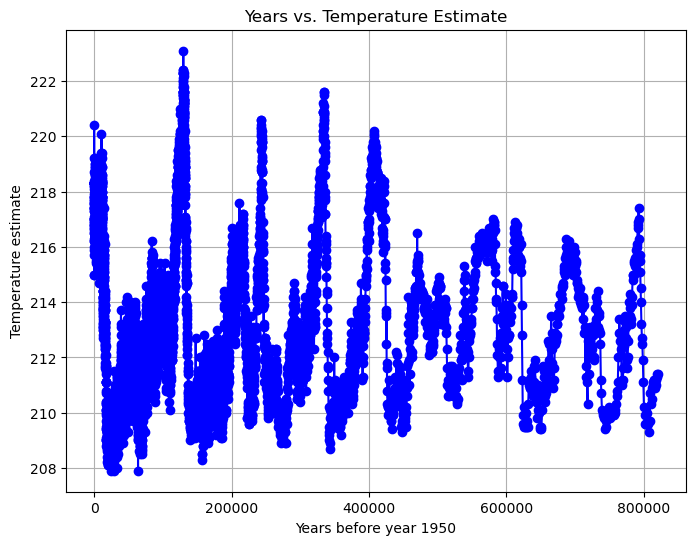

In [329]:
Deuterium = noaa['Deuterium']
Temperature = noaa['Temperature']

# Plotting the data
plt.figure(figsize=(8, 6))
plt.plot(edc3_age, temperature_estimate, marker='o', linestyle='-', color='blue')
plt.xlabel('Years before year 1950')
plt.ylabel('Temperature estimate')
plt.title('Years vs. Temperature Estimate')
plt.grid(True)
plt.show()

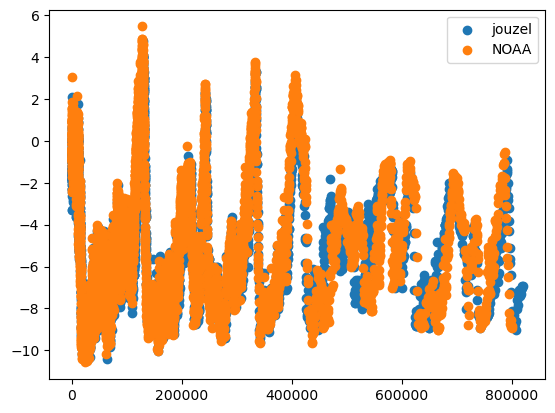

In [330]:
plt.scatter(jouzel['EDC3béta'],jouzel['difference'], label = 'jouzel')
plt.scatter(noaa['Age'],noaa['Temperature'], label = 'NOAA')
plt.legend()
plt.show()

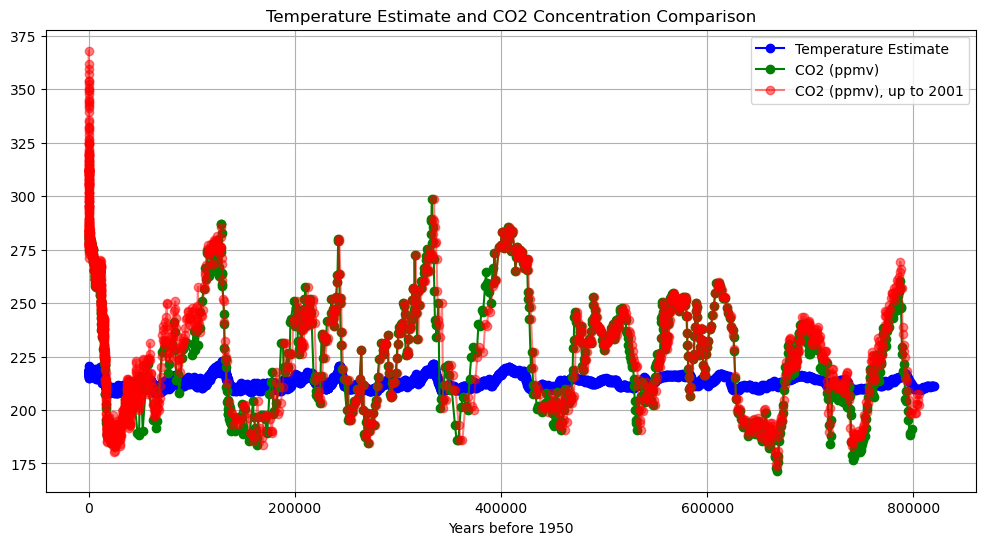

In [331]:
plt.figure(figsize=(12, 6))

# Plotting the first dataset
plt.plot(edc3_age, temperature_estimate, marker='o', linestyle='-', color='blue', label='Temperature Estimate')

# Plotting the second dataset
plt.plot(years, co2, marker='o', linestyle='-', color='green', label='CO2 (ppmv)')

# Plotting the third dataset
plt.plot(Gasage, co22, marker='o', linestyle='-', color='red', label='CO2 (ppmv), up to 2001', alpha=0.5)

plt.xlabel('Years before 1950')
plt.grid(True)
plt.legend()
plt.title('Temperature Estimate and CO2 Concentration Comparison')
plt.show()

# rainfall and tempature in Ireland 

wikipedia states 'Rainfall is the most common form of precipitation on the island, and is extremely common throughout Ireland, although some parts of the west coast receive twice as much rain as the east coast. Rainfall in Ireland normally comes from Atlantic frontal systems which travel northeast over the island, bringing cloud and rain. Most of the eastern half of the country has between 750 and 1,000 mm (29.5 and 39.4 in) of rainfall in the year'. In Ireland 2023 was recorded as the warmest on records, mean annual average temperature in Ireland surpassed 11 degrees for the first time last year That is almost 1.5 degrees above the long-term average and 2024 is expected to rise again. 

However 2023 is also one of the  wettest years since records started to be kept nationally in 1940. It was the wettest year since 2002 at Dublin Airport, and the wettest on record in Athenry since records began 12 years ago. It was also the wettest year since 2009 in Valentia, Co Kerry, and at Cork Airport. We also seen the flooding in middelton co cork this year combine with this he nearest Met Éireann weather station to Midleton is located at Roches Point, Co Cork - about 12km away as the crow flies.


The data analysed here showed the increase in autumn warm days is greatest at Roches Point and is rising by 11.9% for every 1C increase in global temperature. The rainfall intensity at Roches Point is also specifically highlighted as "unusual" relative to our early industrial climate.

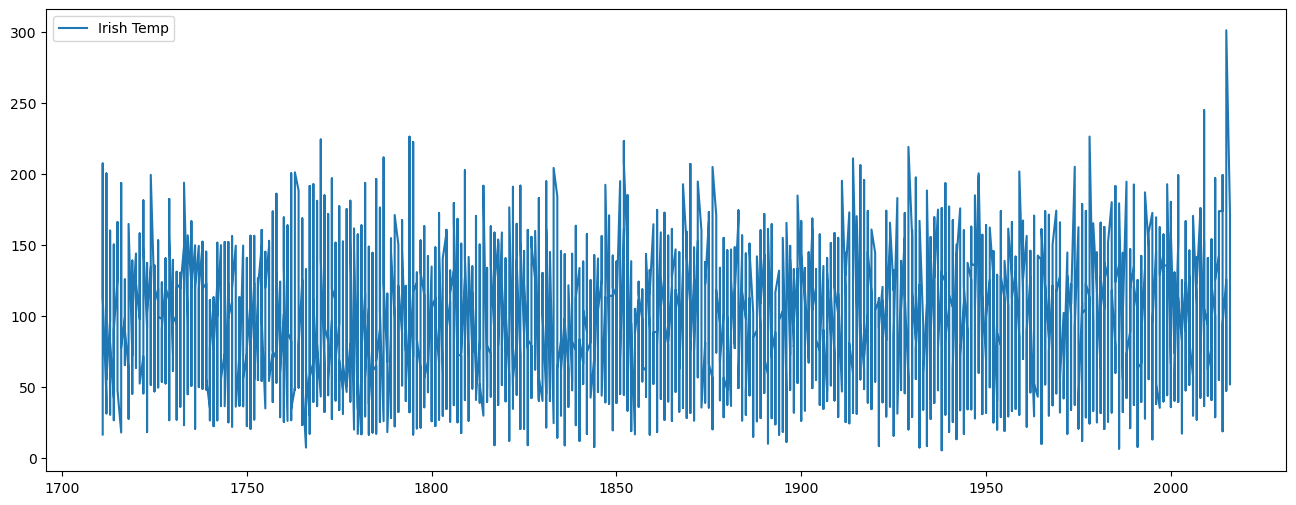

In [332]:
Irish_rainfall = pd.read_csv('data/Rainfall.CSV')
plt.figure(figsize=(16, 6))


plt.plot(Irish_rainfall['Year'],Irish_rainfall['Median montly series'], label = 'Irish Temp')
plt.legend()
plt.show()

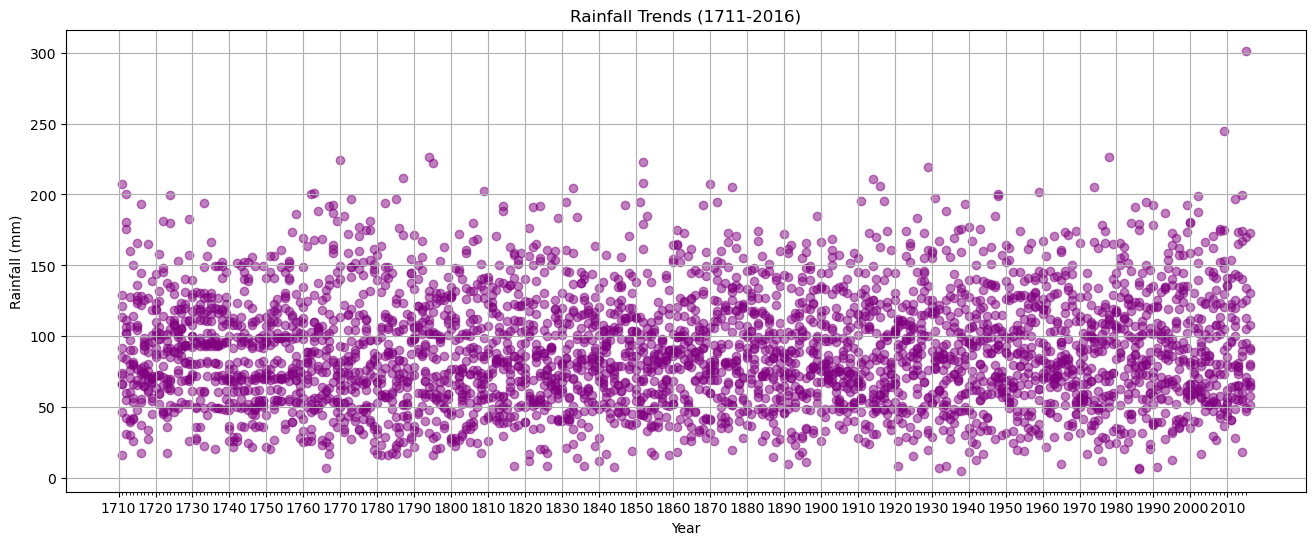

In [333]:
plt.figure(figsize=(16, 6))
ax = plt.gca()

# Plotting the data as individual points
plt.scatter(Irish_rainfall['Year'], Irish_rainfall['Median montly series'], color='purple', alpha=0.5)

# Set x-axis major ticks every 10 years
major_ticks = range(1710, 2017, 10)
ax.set_xticks(major_ticks)

# Set minor ticks between major ticks
minor_ticks = range(1711, 2016, 1)
ax.set_xticks(minor_ticks, minor=True)

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Rainfall (mm)')
plt.title('Rainfall Trends (1711-2016)')

# Show grid and plot
plt.grid(True)
plt.show()

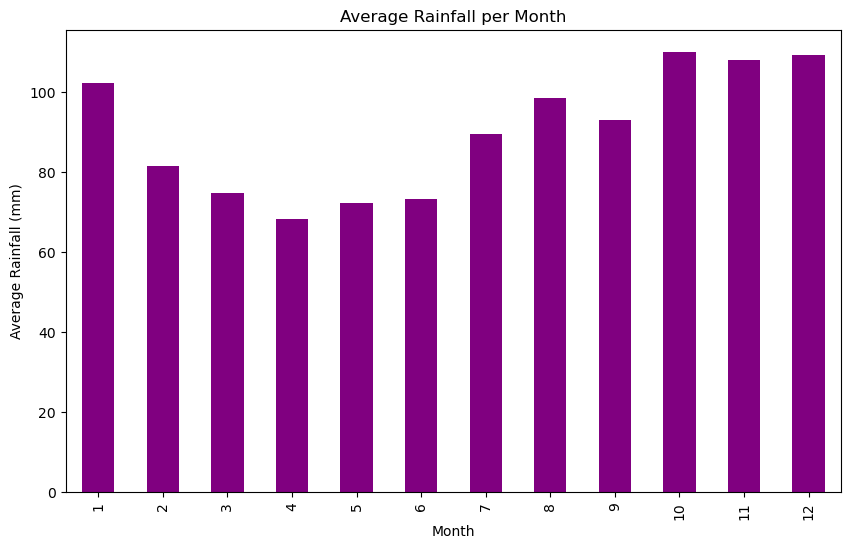

In [334]:
rainfall = Irish_rainfall.groupby('Month')['Median montly series'].mean()

plt.figure(figsize=(10, 6))
rainfall.plot(kind='bar', color='purple')
plt.xlabel('Month')
plt.ylabel('Average Rainfall (mm)')
plt.title('Average Rainfall per Month')
plt.show()

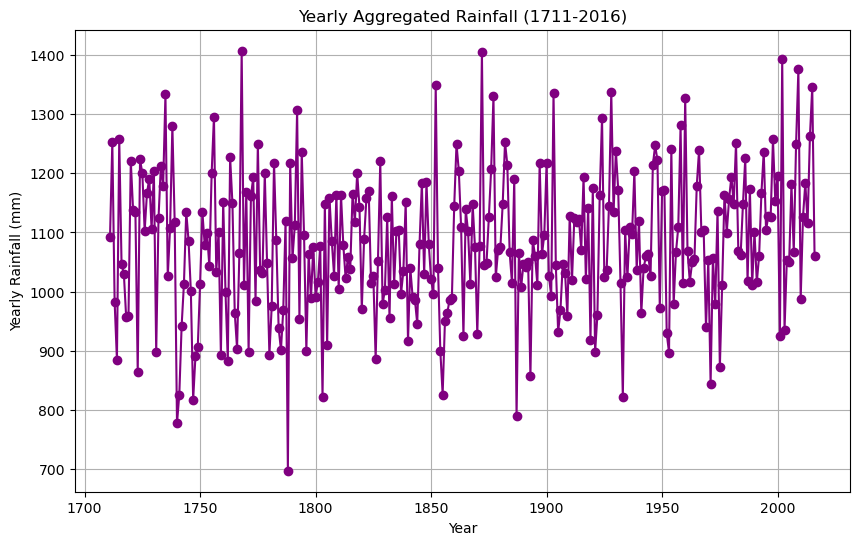

In [335]:
Irish_rainfall['Date'] = pd.to_datetime(Irish_rainfall[['Year', 'Month']].assign(day=1))


yearly_rainfall = Irish_rainfall.groupby(Irish_rainfall['Date'].dt.year)['Median montly series'].sum()


plt.figure(figsize=(10, 6))
plt.plot(yearly_rainfall.index, yearly_rainfall.values, marker='o', linestyle='-', color='purple')
plt.xlabel('Year')
plt.ylabel('Yearly Rainfall (mm)')
plt.title('Yearly Aggregated Rainfall (1711-2016)')
plt.grid(True)
plt.show()

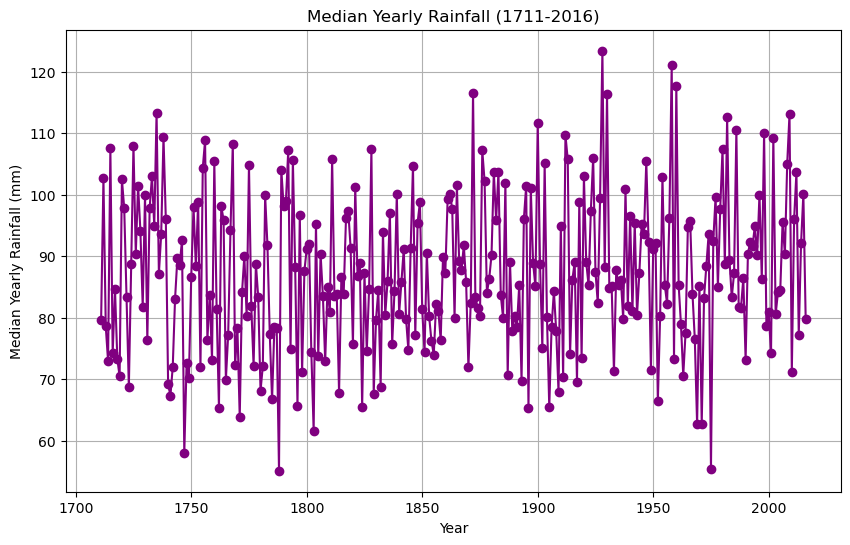

In [336]:
Irish_rainfall['Date'] = pd.to_datetime(Irish_rainfall[['Year', 'Month']].assign(day=1))

# Calculate median yearly rainfall
yearly_median_rainfall = Irish_rainfall.groupby(Irish_rainfall['Date'].dt.year)['Median montly series'].median()

# Plot the median yearly rainfall data
plt.figure(figsize=(10, 6))
plt.plot(yearly_median_rainfall.index, yearly_median_rainfall.values, marker='o',  color='purple')
plt.xlabel('Year')
plt.ylabel('Median Yearly Rainfall (mm)')
plt.title('Median Yearly Rainfall (1711-2016)')
plt.grid(True)
plt.show()

In [337]:
irish_temp = pd.read_csv('data/IrelandMean.csv')

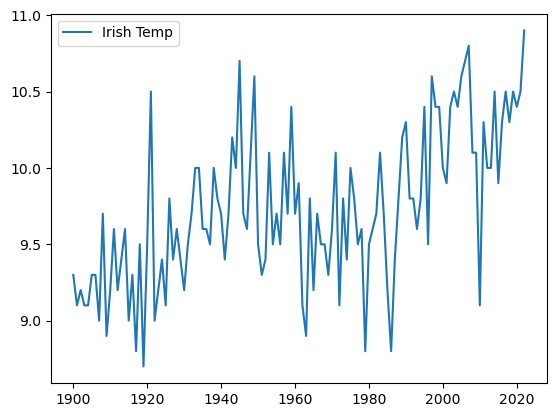

In [338]:
plt.plot(irish_temp['year'],irish_temp['Annual'], label = 'Irish Temp')
plt.legend()
plt.show()

# methane 
more commonly referred to CH4 is a colourless and odourless gas that occurs abundantly in nature and as a product of certain human activities. methane is mostly produced by bogs and cows releasing it in to the athmosphire. However but it's by far mostly human activity that's driving up levels of this destructive greenhouse gas.  methane is a potent greenhouse gas—about 28 times more powerful than carbon dioxide at warming the Earth, on a 100-year timescale, and more than 80 times more powerful over 20 years. The effects aren’t just hypothetical: Since the Industrial Revolution, methane concentrations in the atmosphere have more than doubled, and about 20 percent of the warming the planet has experienced can be attributed to the gas. This would link back into the earlier section on tempature change when discussing tempature change we also seen that this rise was linked to the industral recvolution. 

In terms of the Irish context been a massivly argiculrtle area, teagasc states "The reporting of Irish GHG emissions in 2020 attributes 58% of Irish agri emissions to methane produced by the rumen of cattle and sheep. A further 10% of national agricultural emissions originated from methane associated with the storage of manure and slurry. This is produced by microbes that have passed through the animal in the faeces. Methane associated with ruminant livestock production accounts for two-thirds (68%) of Irish agricultural GHG emissions"



In [339]:
methane =pd.read_csv('data/methane_data.csv',encoding='Latin')

In [340]:
methane_noaa = pd.read_csv('data/Methane NOAA.csv',encoding='Latin',delimiter=r"\s+")

In [341]:
methane_noaa.columns = methane_noaa.columns.str.lstrip()
methane_noaa.columns = methane_noaa.columns.str.rstrip()

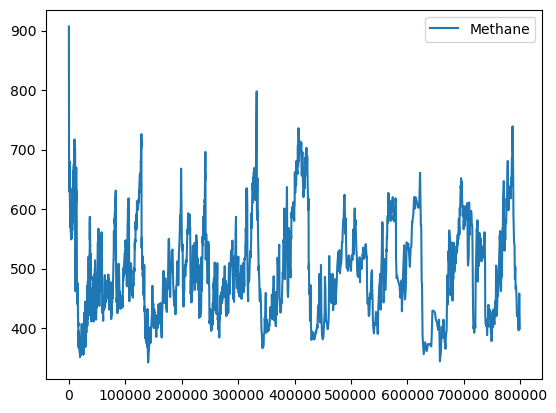

In [342]:
plt.plot(methane['gas age (edc3_gas_a)'],methane['CH4 mean'], label = 'Methane')

plt.legend()
plt.show()

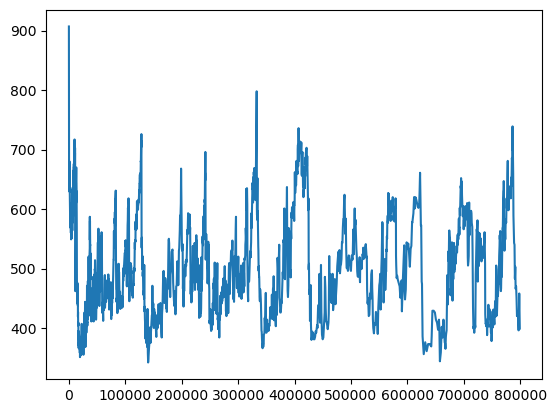

In [343]:
plt.plot(methane_noaa['Age'],methane_noaa['CH4_mean'], label = 'Methane2')

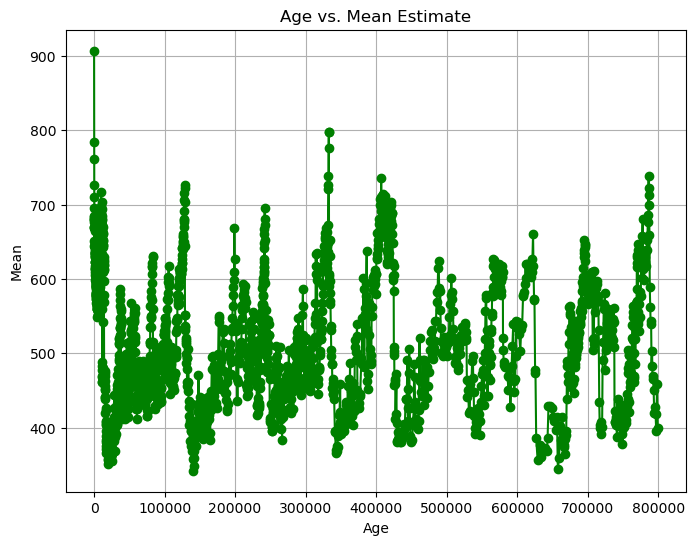

In [344]:
Age = methane_noaa['Age']
CH4_mean = methane_noaa['CH4_mean']

# Plotting the data
plt.figure(figsize=(8, 6))
plt.plot(Age, CH4_mean, marker='o', linestyle='-', color='green')
plt.xlabel('Age')
plt.ylabel('Mean')
plt.title('Age vs. Mean Estimate')
plt.grid(True)
plt.show()

In [345]:
merged = pd.concat([nature,ipcc,mlo,noaa,jouzel,Irish_rainfall,yearly_median_rainfall,irish_temp,methane_noaa],axis =1)

In [346]:
merged

,EDC3_gas_a (yr),CO2 (ppmv),Gasage (yr BP),CO2 (ppmv),sigma mean CO2 (ppmv),EDC3_gas_a (yr),CO2 (ppmv),unc,Bag,ztop,...,Median montly series,Date,Median montly series,year,Annual,ï»¿Depth,Age,CH4_mean,1s,Lab.
0,137.0,280.4,-51.030000,368.022488,0.060442,-9.0,315.98,0.12,1.0,0.00,...,16.4,1711-01-01,NaN,2022.0,10.9,99.34,13.0,907.0,10.0,b
1,268.0,274.9,-48.000000,361.780737,0.370000,-10.0,316.91,0.12,2.0,0.55,...,73.1,1711-02-01,NaN,2021.0,10.5,102.45,126.0,784.0,10.0,g
2,279.0,277.9,-46.279272,359.647793,0.098000,-11.0,317.64,0.12,3.0,1.10,...,121.2,1711-03-01,NaN,2020.0,10.4,102.58,130.0,762.0,10.0,b
3,395.0,279.1,-44.405642,357.106740,0.159923,-12.0,318.45,0.12,4.0,1.65,...,85.2,1711-04-01,NaN,2019.0,10.5,103.34,151.0,710.0,10.0,g
4,404.0,281.9,-43.080000,353.946685,0.043007,-13.0,318.99,0.12,5.0,2.20,...,66.6,1711-05-01,NaN,2018.0,10.3,104.33,184.0,727.0,10.0,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5814,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5815,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5816,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [347]:
merged.to_csv('combined_temp.csv', encoding='utf-8', index=False)

In [348]:
merged.to_json('combined_temps.json', orient='split')

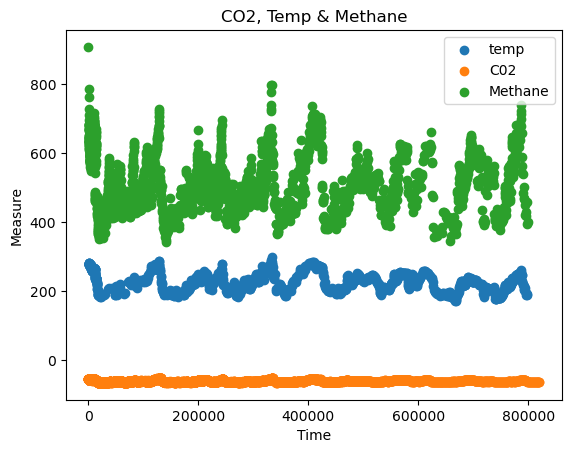

In [349]:
plt.scatter(nature['EDC3_gas_a (yr)'],nature['CO2 (ppmv)'], label = 'temp')
plt.scatter(jouzel['EDC3béta'],jouzel['celsius'], label = 'C02')
plt.scatter(methane['gas age (edc3_gas_a)'],methane['CH4 mean'], label = 'Methane')
plt.xlabel('Time')
plt.ylabel('Measure')
plt.title('CO2, Temp & Methane')
plt.legend()
plt.show()


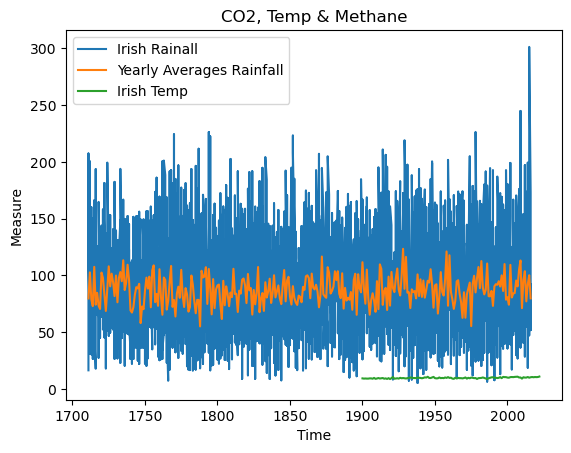

In [350]:
plt.plot(Irish_rainfall['Year'],Irish_rainfall['Median montly series'], label = 'Irish Rainall')
plt.plot(yearly_median_rainfall, label='Yearly Averages Rainfall')
plt.plot(irish_temp['year'],irish_temp['Annual'], label = 'Irish Temp')
plt.xlabel('Time')
plt.ylabel('Measure')
plt.title('CO2, Temp & Methane')
plt.legend()
plt.show()

# using histograms to show Distribution of the Variables

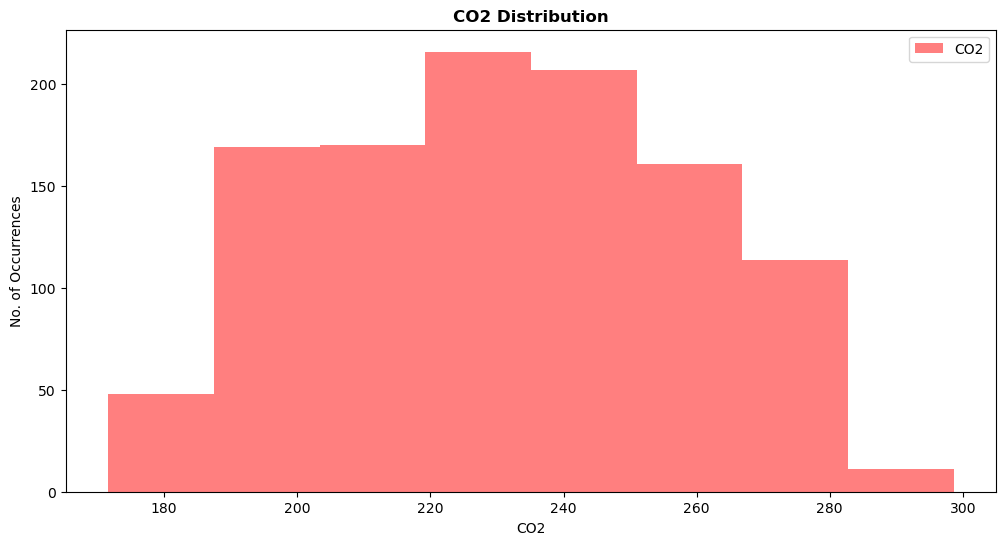

In [351]:
fig, ax = plt.subplots(figsize = (12,6))

ax.set_title("CO2 Distribution", fontweight='bold') 
ax.set(xlabel='CO2')    
ax.set(ylabel="No. of Occurrences") 
ax.hist(nature['CO2 (ppmv)'], bins=8, alpha=0.5, label="CO2", color='red')  
ax.legend(loc='upper right')

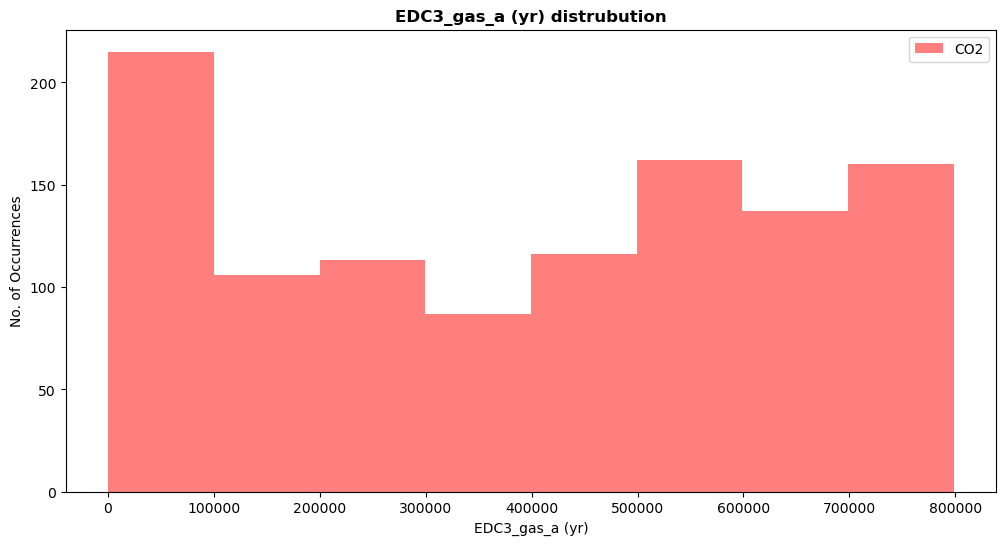

In [352]:
fig, ax = plt.subplots(figsize = (12,6))

ax.set_title("EDC3_gas_a (yr) distrubution", fontweight='bold') 
ax.set(xlabel='EDC3_gas_a (yr)')    
ax.set(ylabel="No. of Occurrences") 
ax.hist(nature['EDC3_gas_a (yr)'], bins=8, alpha=0.5, label="CO2", color='red')  
ax.legend(loc='upper right')

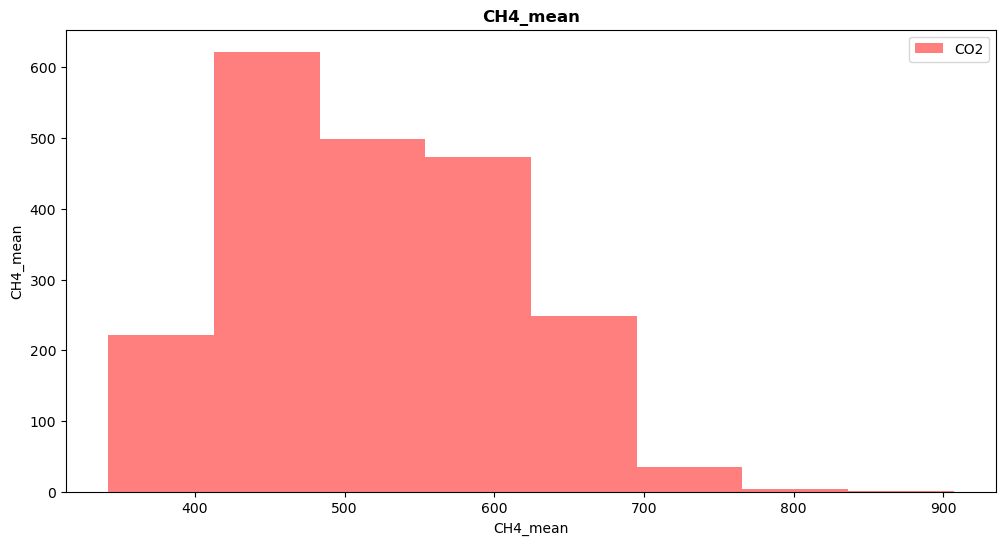

In [353]:
fig, ax = plt.subplots(figsize = (12,6))

ax.set_title("CH4_mean", fontweight='bold') 
ax.set(xlabel='CH4_mean')    
ax.set(ylabel="CH4_mean") 
ax.hist(methane_noaa['CH4_mean'], bins=8, alpha=0.5, label="CO2", color='red')  
ax.legend(loc='upper right')

# Fourier transform

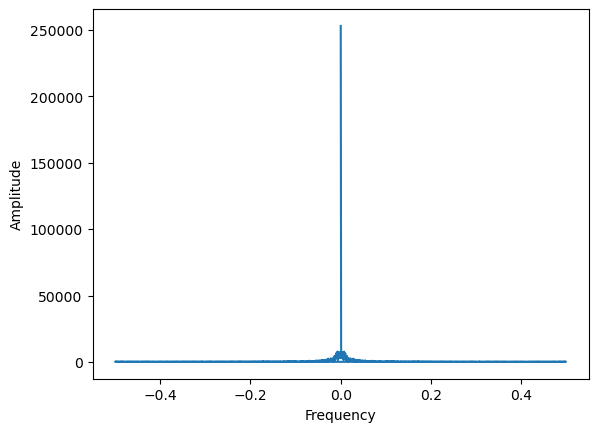

In [354]:
y = nature['CO2 (ppmv)']
y = np.ascontiguousarray(y)
yf = fft(y) 
xf = fftfreq(y.size)
plt.plot(xf, np.abs(yf)) 
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.show()

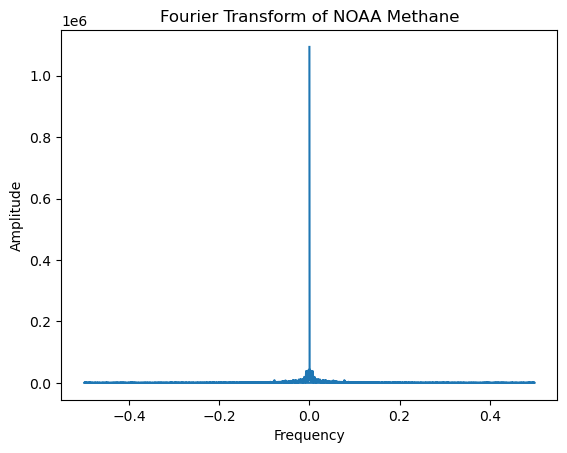

In [355]:
y = methane_noaa["CH4_mean"].to_numpy()
#y = np.ascontiguousarray(y)

yf = np.fft.fft(y) # Frequency spectrum
#yf= np.absolute(yf)
xf = fftfreq(y.size)
plt.plot(xf, np.abs(yf)) # Plot the magnitude of the spectrum
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title('Fourier Transform of NOAA Methane')
plt.show()

# Lead lag/Analysis
1. CO2 vs Temperature anomaly
2. Temperature anomaly vs Methane
3. CO2 vs Methane
4. CO2 vs irish rainfall
5. Irish temp vs irish rainfall

In [382]:
test1=mergeddf['CO2 (ppmv)']
test2=noaa2['Temperature']
test3=methane_noaa['CH4_mean']
test4= yearly_rainfall
test5=irish_temp['Annual']

In [383]:
from scipy import signal
corr = signal.correlate(test1,test2,mode='same')

n = len(corr)
lags = np.linspace(-n/2, n/2, n)


max_lag = lags[np.argmax(corr)]

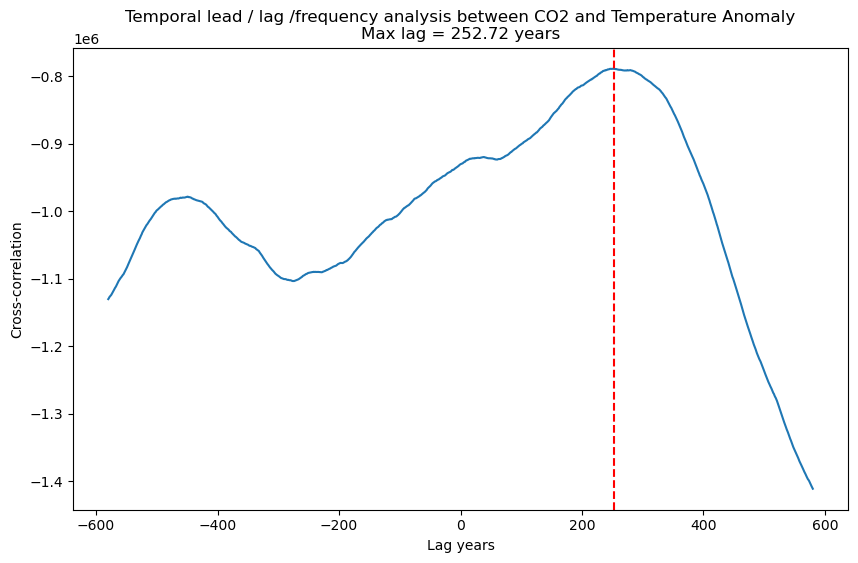

In [384]:
plt.figure(figsize=(10, 6))
plt.plot(lags, corr)
plt.axvline(max_lag, color='red', linestyle='--')
plt.xlabel('Lag years')
plt.ylabel('Cross-correlation')
plt.title(f'Temporal lead / lag /frequency analysis between CO2 and Temperature Anomaly\nMax lag = {max_lag:.2f} years')
#plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


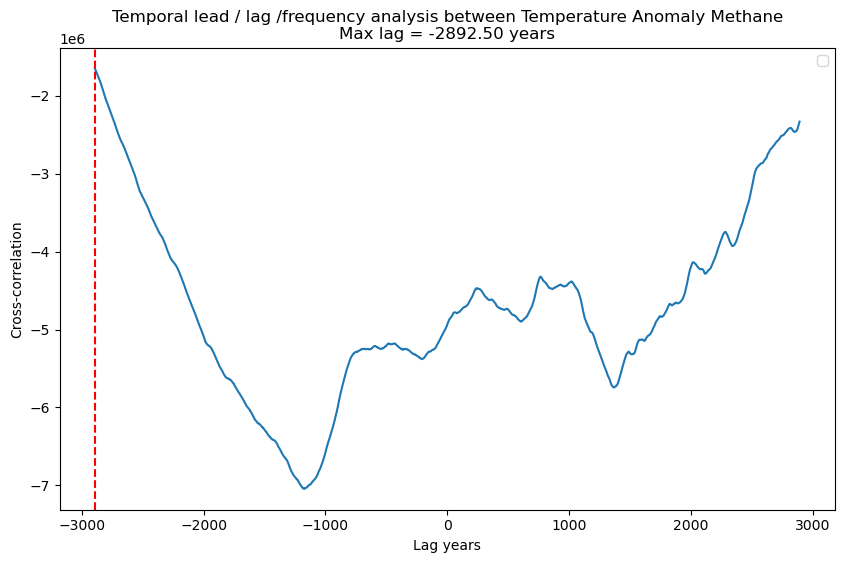

In [385]:
corr = signal.correlate(test2,test3,mode='same')

n = len(corr)
lags = np.linspace(-n/2, n/2, n)


max_lag = lags[np.argmax(corr)]
plt.figure(figsize=(10, 6))
plt.plot(lags, corr)
plt.axvline(max_lag, color='red', linestyle='--')
plt.xlabel('Lag years')
plt.ylabel('Cross-correlation')
plt.title(f'Temporal lead / lag /frequency analysis between Temperature Anomaly Methane\nMax lag = {max_lag:.2f} years')
plt.legend()
plt.show()

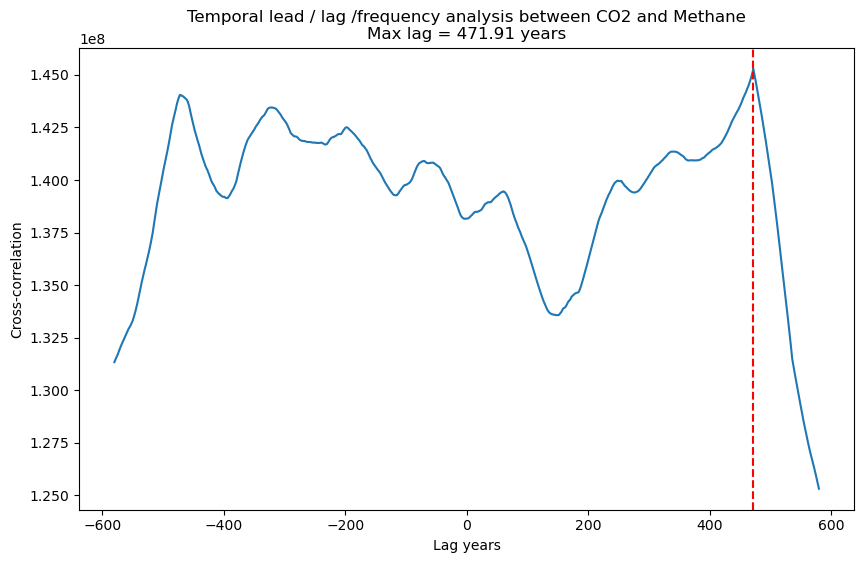

In [386]:
corr = signal.correlate(test1,test3,mode='same')

n = len(corr)
lags = np.linspace(-n/2, n/2, n)

max_lag = lags[np.argmax(corr)]
plt.figure(figsize=(10, 6))
plt.plot(lags, corr)
plt.axvline(max_lag, color='red', linestyle='--')
plt.xlabel('Lag years')
plt.ylabel('Cross-correlation')
plt.title(f'Temporal lead / lag /frequency analysis between CO2 and Methane\nMax lag = {max_lag:.2f} years')
#plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


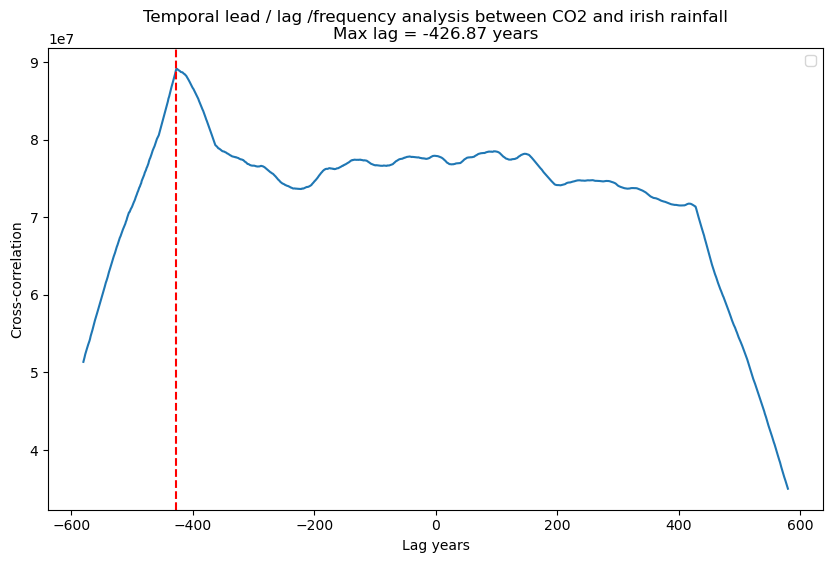

In [387]:
corr = signal.correlate(test1,test4,mode='same')

n = len(corr)
lags = np.linspace(-n/2, n/2, n)


max_lag = lags[np.argmax(corr)]
plt.figure(figsize=(10, 6))
plt.plot(lags, corr)
plt.axvline(max_lag, color='red', linestyle='--')
plt.xlabel('Lag years')
plt.ylabel('Cross-correlation')
plt.title(f'Temporal lead / lag /frequency analysis between CO2 and irish rainfall\nMax lag = {max_lag:.2f} years')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


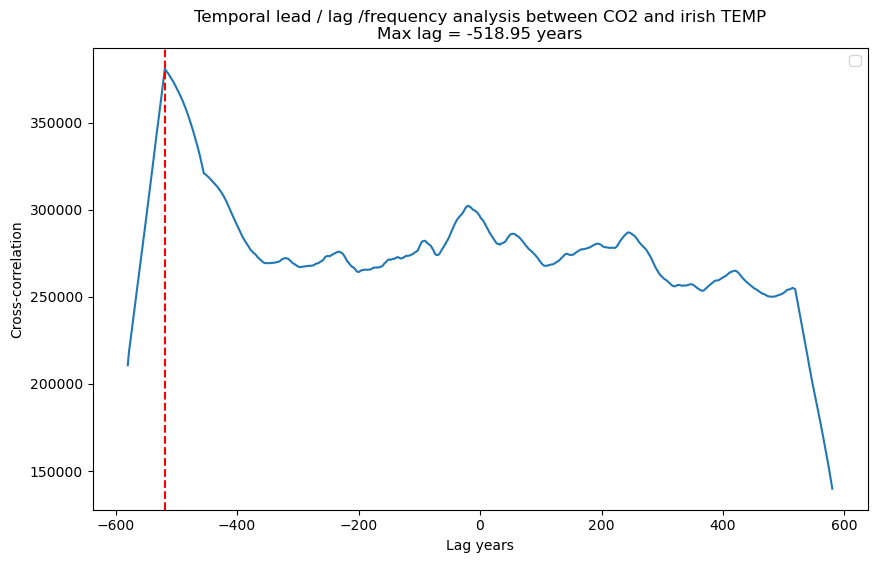

In [388]:
corr = signal.correlate(test1,test5,mode='same')

n = len(corr)
lags = np.linspace(-n/2, n/2, n)


max_lag = lags[np.argmax(corr)]
plt.figure(figsize=(10, 6))
plt.plot(lags, corr)
plt.axvline(max_lag, color='red', linestyle='--')
plt.xlabel('Lag years')
plt.ylabel('Cross-correlation')
plt.title(f'Temporal lead / lag /frequency analysis between CO2 and irish TEMP\nMax lag = {max_lag:.2f} years')
plt.legend()
plt.show()

# Frequency Analysis

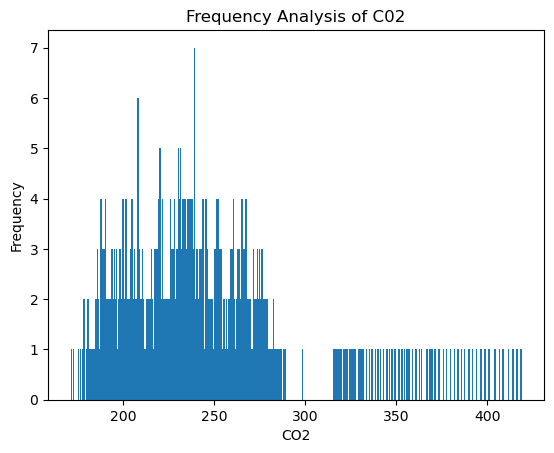

In [389]:
freq = test1.value_counts()

#plot the frequencies as a bar chart
plt.bar(freq.index, freq.values)
plt.xlabel("CO2")
plt.ylabel("Frequency")
plt.title("Frequency Analysis of C02")
plt.show()

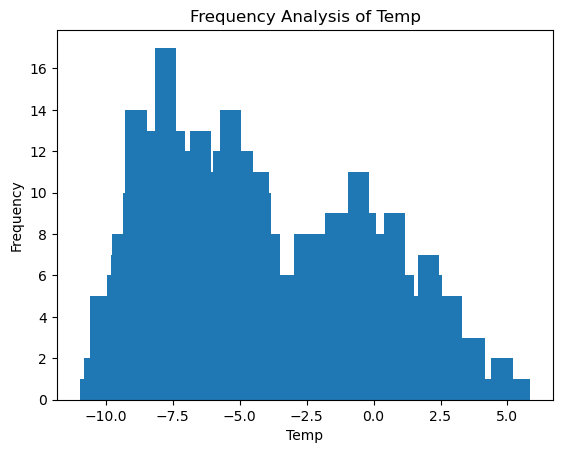

In [390]:
freq = test2.value_counts()

#plot the frequencies as a bar chart
plt.bar(freq.index, freq.values)
plt.xlabel("Temp")
plt.ylabel("Frequency")
plt.title("Frequency Analysis of Temp")
plt.show()

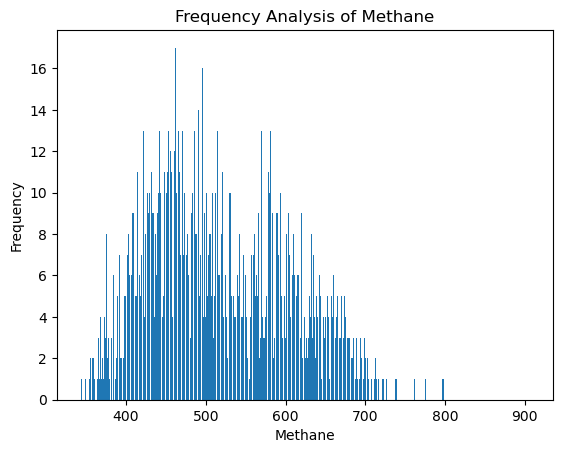

In [391]:
freq = test3.value_counts()

#plot the frequencies as a bar chart
plt.bar(freq.index, freq.values)
plt.xlabel("Methane")
plt.ylabel("Frequency")
plt.title("Frequency Analysis of Methane")
plt.show()

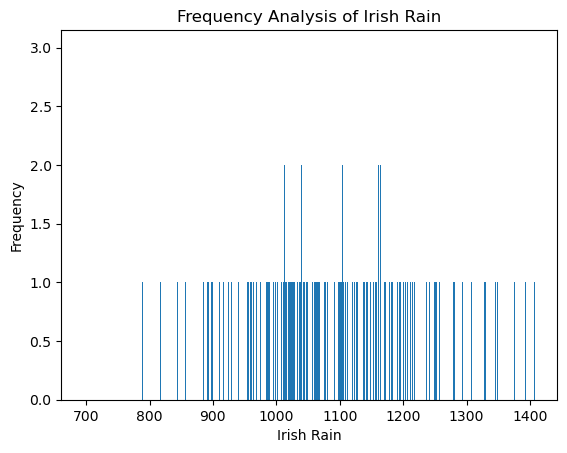

In [392]:
freq = test4.value_counts()

#plot the frequencies as a bar chart
plt.bar(freq.index, freq.values)
plt.xlabel("Irish Rain")
plt.ylabel("Frequency")
plt.title("Frequency Analysis of Irish Rain")
plt.show()

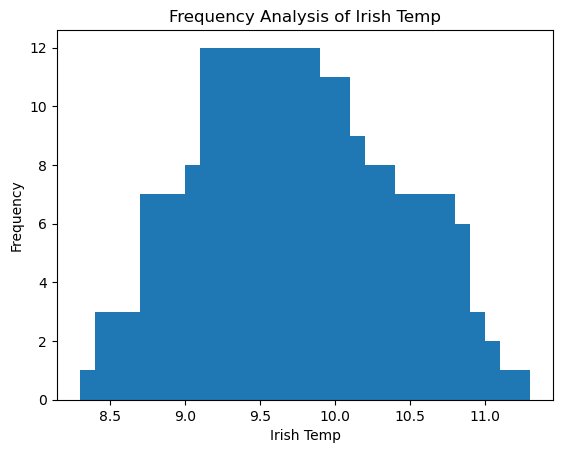

In [393]:
freq = test5.value_counts()

#plot the frequencies as a bar chart
plt.bar(freq.index, freq.values)
plt.xlabel("Irish Temp")
plt.ylabel("Frequency")
plt.title("Frequency Analysis of Irish Temp")
plt.show()

In [394]:
mean_temp = pd.read_csv('data/Mean temp anomaly 1985-2023.csv')

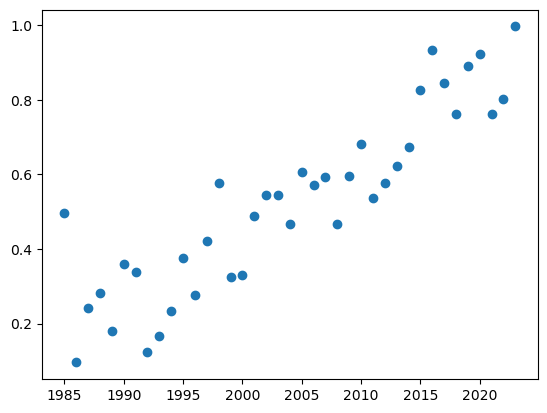

In [395]:
plt.scatter(mean_temp['year'],mean_temp['anomaly'], label = 'mean_temp_anomaly')

In [396]:
mean_temp = mean_temp.copy()
mean_temp['time'] = np.arange(len(mean_temp.index))
mean_temp

,year,anomaly,time
0,1985,0.497300,0
1,1986,0.095687,1
2,1987,0.243026,2
3,1988,0.282152,3
4,1989,0.179250,4
5,1990,0.360562,5
6,1991,0.338897,6
7,1992,0.124897,7
8,1993,0.165658,8
9,1994,0.233550,9


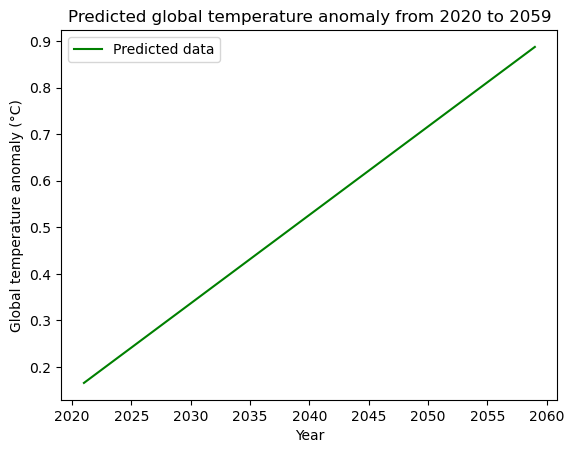

In [397]:
xt = mean_temp.loc[:, ['time']]  # features
yt = mean_temp.loc[:, 'anomaly']  # target

# Train the model
model = LinearRegression()
model.fit(xt, yt)

# Store the fitted values as a time series with the same time index as
# the training data
y_predt = pd.Series(model.predict(xt), index=xt.index)
future_years = pd.date_range(start='2020', end='2059', freq='Y') # Create a date range of future years
plt.plot( future_years,y_predt, color='green', label='Predicted data')
plt.xlabel('Year')
plt.ylabel('Global temperature anomaly (°C)')
plt.title('Predicted global temperature anomaly from 2020 to 2059')
plt.legend()
plt.show()

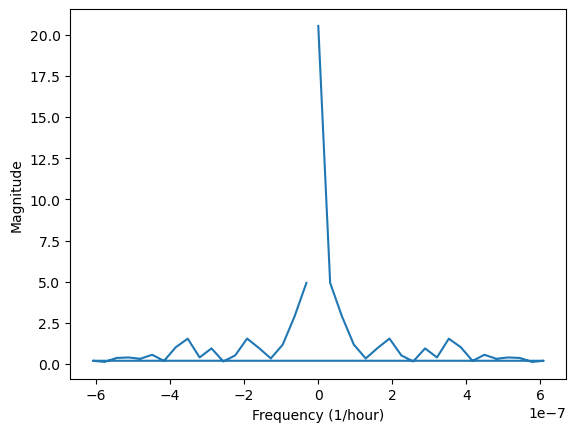

In [398]:
y = mean_temp['anomaly'].to_numpy()

T = 800000.0 
N = len(y) 


yf = fft(y) 
xf = fftfreq(N, T) 

import matplotlib.pyplot as plt
plt.plot(xf, np.abs(yf))
plt.xlabel("Frequency (1/hour)")
plt.ylabel("Magnitude")
plt.show()

As we can see from the above graphs the climate of the World  will continue to warm. This confirms the earlier comments about global warming. We can also see from above graphs that this is steady rise of 1.5°C. 

# conclusion 
In this comprehensive analysis of paleo-present climate data, many key climate variables were explored, such as CO2 concentrations, temperature anomalies, and CH4 concentrations spanning the last 800,000 years. The examination of the CO2 vs Temperature Anomaly relationship revealed valuable insights into the dynamis of Earths climate systems. The fusion and analysis of various data sources into different DataFrames allowed for the examination of the variables of interest. For future analyeses, the datasets were exported to both CSV and JSON formats.

Climate change can lead to shifts in temperature, atmospheric circulation, and precipitation patterns. The natural climate cycles of Earth's climate, ocean circulation, and the carbon cycle have all contributed to the glacial and interglacial periods Earth has experienced over the last 800kyrs. However, in recent years there has been an exponetial growth in CO2 concentrations and temperature. 

In conclusion, this project integrates scientific inquiry, data analysis, and predictive modeling to allow for better understanding of climate dynamics. The historical data combined with the present data provides proof that humans are the main reason for climate change today. The urgency of addressing accelerated warming and its effects underscores the need for sustained research, interdisciplinary collaboration, and global initiatives aimed at preserving the delicate balance of our planet's climate. Future work on this project could include delving deeper into the analysis CO2 concentration, temperature anomolies, CH4 concentration, and rainfall in Ireland.